# TRATAMIENTO DE SOMBRAS EN FOTOGRAFIAS DE DOCUMENTOS

In [156]:
# importamos librerias utilizadas
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, misc
import matplotlib.pyplot as plt


In [157]:
# definimos unafuncion para graficar las imagenes
def imprimir_pic(pic,etiqueta):
    plt.figure()
    plt.imshow(pic, cmap = 'gray')
    plt.title(etiqueta)
    plt.axis('off')

### Seleccionamos la imagen con la cual se va a trabajar

In [158]:

imagen_entrada = "input8"
input_pic = cv2.imread(imagen_entrada+".jpeg")



# METODO BASE

#### Generamos la mascara o "perfil de sombra"

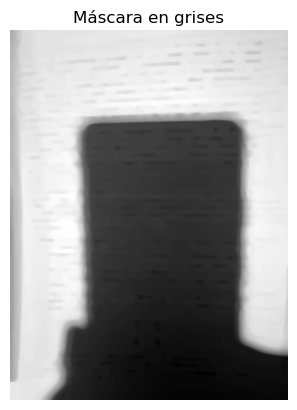

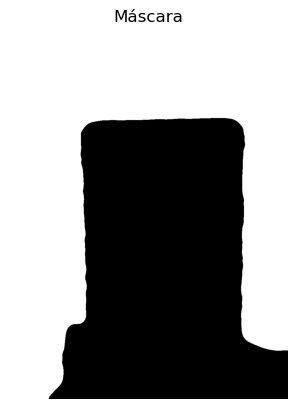

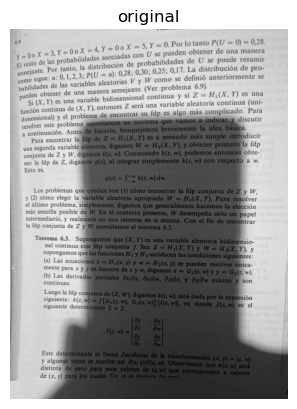

In [159]:

# Paquetes necesarios para la morfología matemática
from skimage.morphology import erosion, dilation, opening, closing
# Elementos estructurales
from skimage.morphology import disk, diamond, ball, rectangle, star
from scipy import ndimage as ndi
#reducimos la pic a grises
input_pic = cv2.cvtColor(input_pic, cv2.COLOR_BGR2GRAY)

#realizamos una copia de la pic recibida para poder modificarla en un espacio de memoria diferente
mask = np.copy(input_pic)
#las sisguientes 3 lineas se encargar de normalizar la pic de 0 a 255
mask = mask - mask.min()
mask = mask/mask.max()
mask = mask*255


#Creamos la mascara con un filtro de mediana, consideramos las letras como ruido 

for i in range(3):
    mask = ndimage.median_filter(mask, size=18,mode='reflect')
    
mask_gris = np.copy(mask)


imprimir_pic(mask,'Máscara en grises')



#la maskara debe estar en blanco y negro y no en escala de grises, asi que se realiza un if:
promedio = np.mean(mask) 
for (cor_y,cor_x), value in np.ndenumerate(mask): 
    if mask[cor_y,cor_x]<promedio: #Good Pixel
        mask[cor_y,cor_x] = 0.1
    elif mask[cor_y,cor_x]>promedio: #Bad Pixel
        mask[cor_y,cor_x] = 254.9


imprimir_pic(mask,'Máscara')
imprimir_pic(input_pic,'original')




### Definimos la funcion de contraste que apartir de un percentil permite 

In [160]:
def funcion_de_contraste(pic,percentil):
    limite = np.percentile(pic,percentil)
    blancos = pic >= limite
    pic = pic + 255*blancos
    negros_saturados = pic<limite
    blancos_saturados = pic>=limite
    pic[negros_saturados] = 0
    pic[blancos_saturados] = 255
    return pic  

### Definimos el array "Zona Oscura"

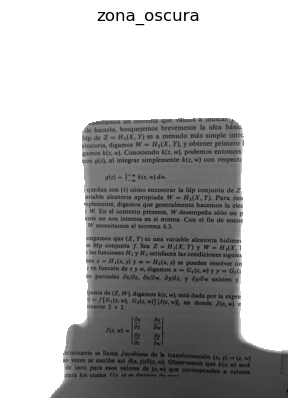

In [161]:
zona_oscura = np.full(input_pic.shape,np.nan)
limite = np.nanmean(input_pic)
for (coor_y,coor_x), value in np.ndenumerate(input_pic): 
    aux = mask[coor_y:coor_y+1,coor_x:coor_x+1]
    if aux<limite: #Good Pixel
        zona_oscura[coor_y,coor_x] =  input_pic[coor_y,coor_x] 
    elif aux>limite: #Bad Pixel
        None             
imprimir_pic(zona_oscura,"zona_oscura")  


### Definimos el array "Zona Clara"

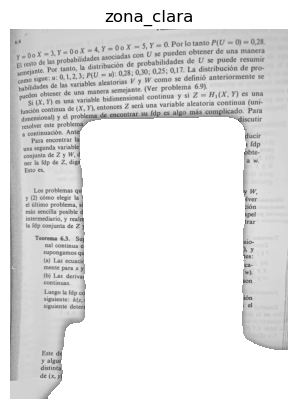

In [162]:
zona_clara = np.full(input_pic.shape,np.nan)
limite = np.nanmean(input_pic)

for (coor_y,coor_x), value in np.ndenumerate(input_pic): 
    aux = mask[coor_y:coor_y+1,coor_x:coor_x+1]
    if aux>limite: #Good Pixel
        zona_clara[coor_y,coor_x] =  input_pic[coor_y,coor_x] 
    elif aux<=limite: #Bad Pixel
        None
        
imprimir_pic(zona_clara,"zona_clara")  


### Definimos la funcion que nos permite conocer el punto optimo para contrastar la imagen 

In [163]:
def contraste_optimo_por_MSE(segmento,pic):  
    
    output = 255 - np.nan_to_num(segmento,nan=0)

    base = 255 -pic
    errorlist = []
    for i in range(30):
        
        f = funcion_de_contraste(output,i)
        error = np.sum((base-f)**2)
        errorlist.append(error)

    m = np.arange(30)
    #plt.scatter( m,errorlist)
    #plt.title("Error vs intensidad (por percentile)")
    #plt.show()
    return (m[np.argmin(errorlist)]+1)

# METODO BASE

#### Obtenemos el histograma de la zona clara con el fin de obtener su moda

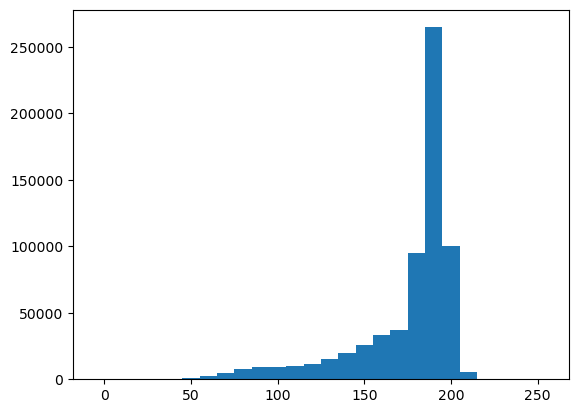

In [164]:
a,b = np.histogram(zona_clara,bins=np.arange(0,270,10))
plt.bar( b[0:26],a[0:26],width=10)
moda_zona_clara = b[np.argmax(a)+1]

#### Obtenemos el histograma de la zona oscura con el fin de obtener su moda

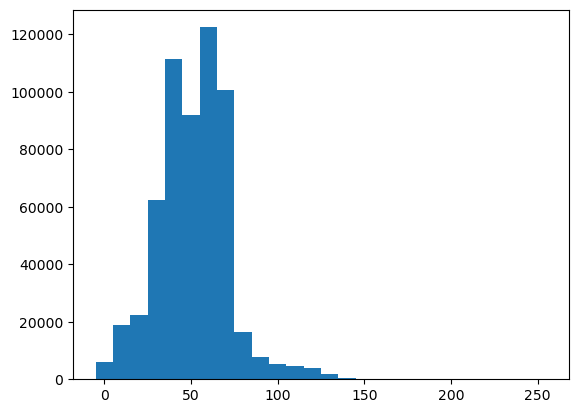

In [165]:
a,b = np.histogram(zona_oscura,bins=np.arange(0,270,10))
plt.bar( b[0:26],a[0:26],width=10)
moda_zona_oscura = b[np.argmax(a)+1]

#### Modificamos el histograma de la zona oscura con el fin de igualar la moda de ambas zonas

<BarContainer object of 26 artists>

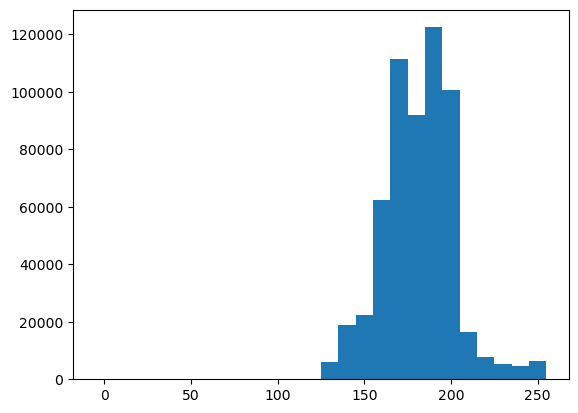

In [166]:
osc = np.copy(zona_oscura) + ( -moda_zona_oscura + moda_zona_clara)
#osc = zona_oscura
lessThen0 = osc<0
moreThen255 = osc>255
osc[lessThen0] = 0
osc[moreThen255] = 255
#imprimir_pic(osc,"osc")
a,b = np.histogram(osc,bins=np.arange(0,270,10))
plt.bar( b[0:26],a[0:26],width=10)
#moda_zona_oscura = b[np.argmax(a)+1]

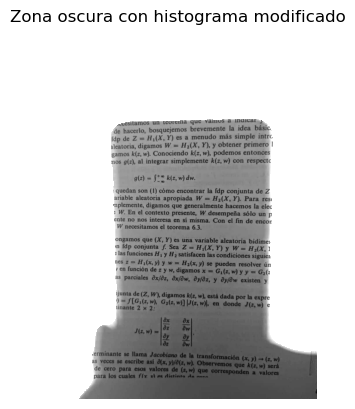

In [167]:
imprimir_pic(osc,"Zona oscura con histograma modificado")

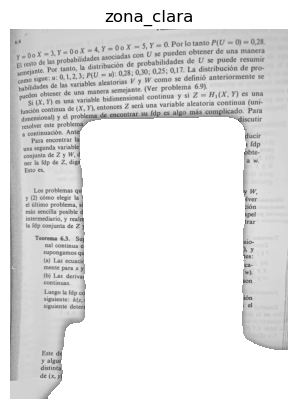

In [168]:
imprimir_pic(zona_clara,"zona_clara")

#### Combinamos ambas zonas: la zona clara y la zona oscura modificada

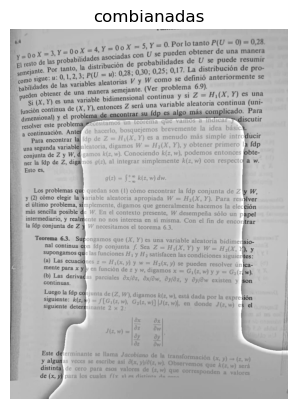

In [169]:
z1 =  np.nan_to_num(zona_clara,0)
z2 = np.nan_to_num(osc,0)

suma_parcial = (z1 + z2)
imprimir_pic(suma_parcial,"combianadas")

####  Restamos las mascara (en tonos de gris) de la imagen original 

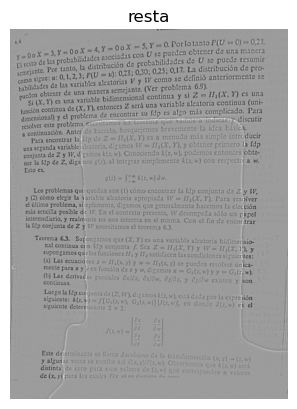

In [170]:

resta_parcial = np.copy(suma_parcial)

mask_gris = ndimage.median_filter(suma_parcial, size=15,mode='reflect')


resta_parcial = ((suma_parcial - mask_gris)+255)/(2)
lessThen0 = resta_parcial<0
moreThen255 = resta_parcial>255
resta_parcial[lessThen0] = 0
resta_parcial[moreThen255] = 255


imprimir_pic(resta_parcial,"resta") 

#### Aplicamos un contraste optmizado por MSE a la imagen de "resta parcial"

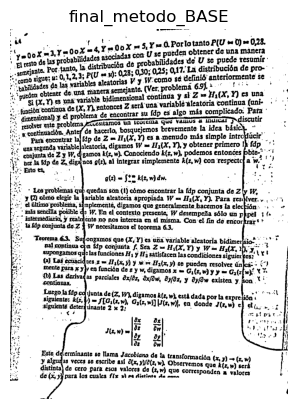

In [171]:


p_indicado = contraste_optimo_por_MSE(255 - resta_parcial,255 - input_pic)
final_metodo_BASE = funcion_de_contraste(resta_parcial,p_indicado)
imprimir_pic(final_metodo_BASE,"final_metodo_BASE") 


# METODO B

In [172]:
# Importar las librearias necesarias:

import matplotlib.pyplot as plt
from PIL import Image
import scipy.ndimage as snd
import numpy as np
import cv2
from skimage.filters import threshold_otsu
from cv2 import threshold, adaptiveThreshold

In [173]:
# Declarar metodos para aplicar Clausura y Threshold:

def closing(image_array):

  # Estructurar elemento de clausura:
  huella = np.ones((40, 40))
  # Aplicar clausura de grises:
  fondo = snd.grey_closing(image_array, footprint=huella)
  # Se resta el fondo de la imagen:
  fondo_libre = (image_array.astype(np.float64) - fondo.astype(np.float64))
  # Se reescala la imagen con el fondo libre de 0 a 255:
  denominador = (fondo_libre.max() - fondo_libre.min())
  fondo_libre_normalizado = (fondo_libre - fondo_libre.min())* 255/denominador
  # Convertir fondo_libre_normalizado a uint8:
  fondo_libre_normalizado = fondo_libre_normalizado.astype(np.uint8)
  # Convertir fondo_libre_normalizado a imagen:
  fondo_libre_normalizado = Image.fromarray(fondo_libre_normalizado)
  return fondo_libre_normalizado


def threshold(image_array):
  th = cv2.adaptiveThreshold(np.asarray(image_array), 
    255,  # Maximo valor assignado al valor de un pixel que excede el 'threshold'.
    cv2.ADAPTIVE_THRESH_MEAN_C,  # suma ponderada "gaussiana" de los vecinos.
    cv2.THRESH_BINARY,  # Tipo de threshold.
    15,  # Tamaño del bloque (ventana 5x5)
    12)
  
  # Convertir th a imagen:
  th = Image.fromarray(th)
  
  return th

In [174]:
# Importar imagen:
input_image = input_pic
# Convertir la imagen en arreglo:
image_array = np.asarray(input_image)
# Aplicar Clausura:
closing_image = closing(image_array)
# Aplicar Threshold:
threshold_image = threshold(closing_image)

In [175]:
input_image

array([[146, 148, 151, ..., 179, 179, 178],
       [141, 143, 146, ..., 179, 178, 178],
       [139, 141, 144, ..., 178, 178, 177],
       ...,
       [190, 190, 190, ...,  36,  36,  36],
       [190, 190, 190, ...,  36,  36,  36],
       [190, 190, 190, ...,  36,  36,  36]], dtype=uint8)

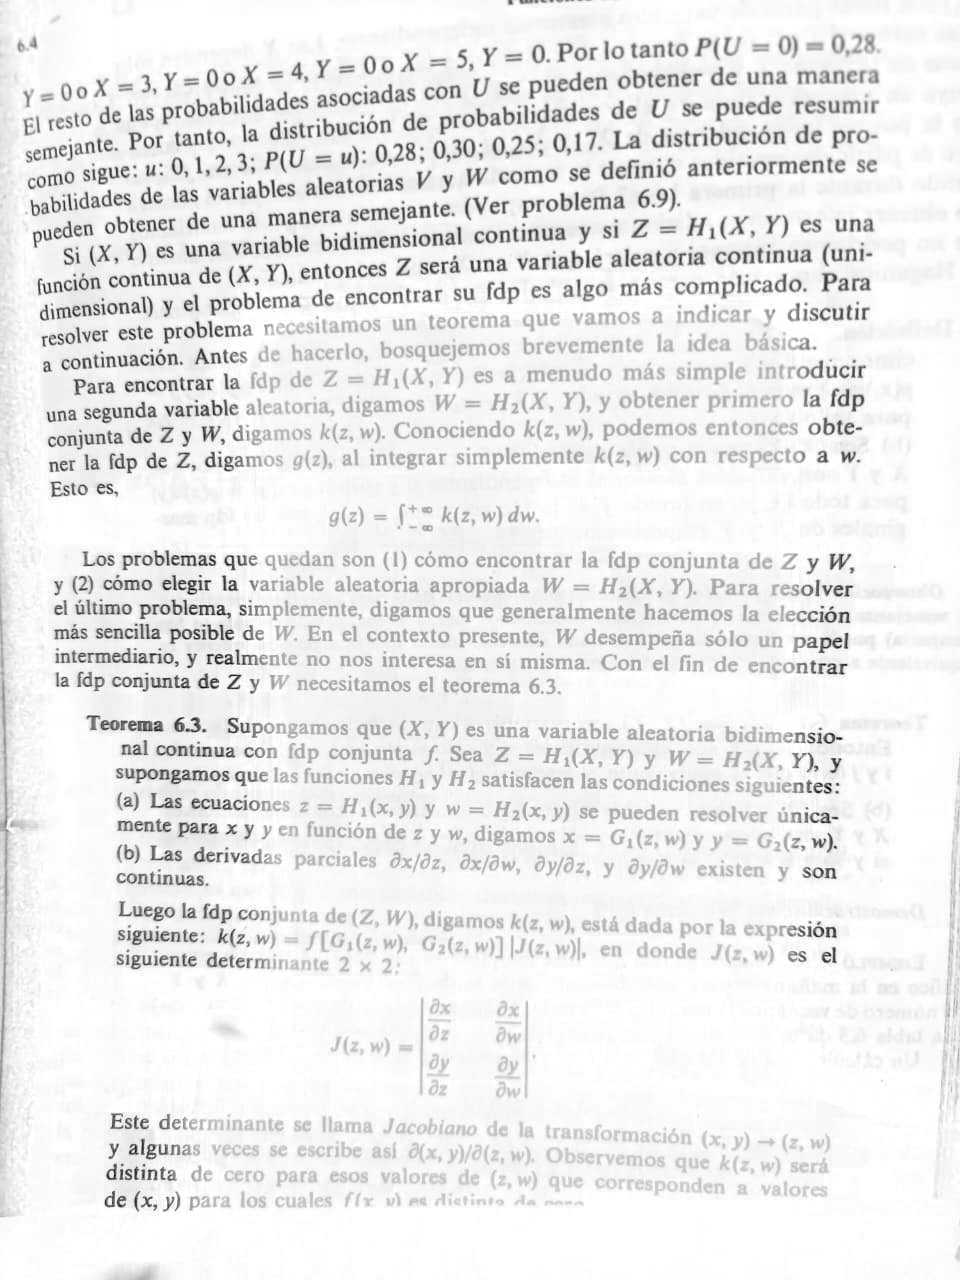

In [176]:
closing_image

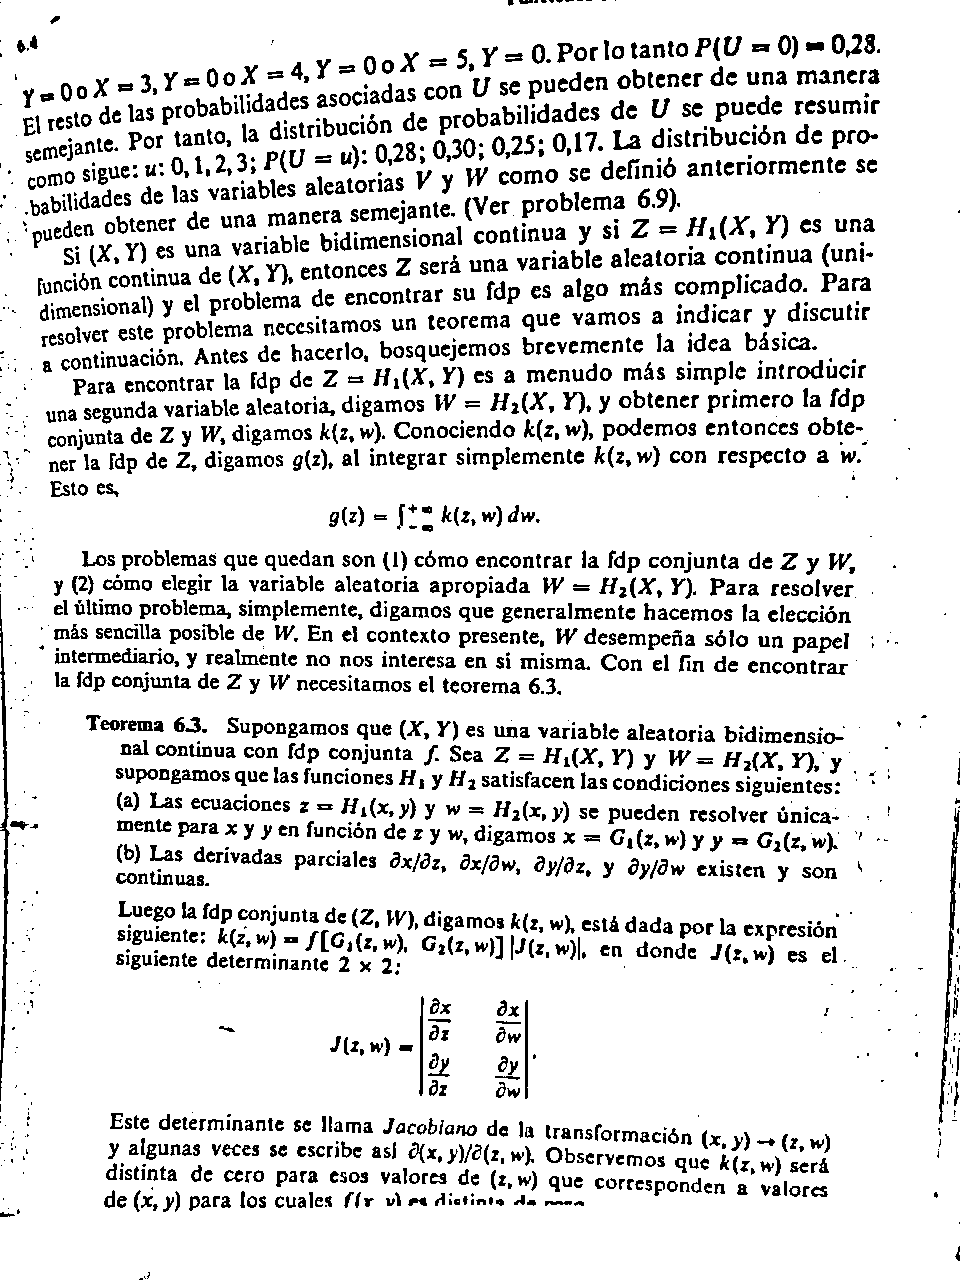

In [177]:
threshold_image

# METODO A 

/tmp/ipykernel_12094/2346952556.py:1: FutureWarning: `selem` is a deprecated argument name for `dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  mask = dilation(image=mask, selem=disk(40))


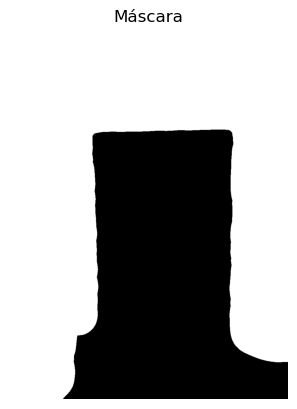

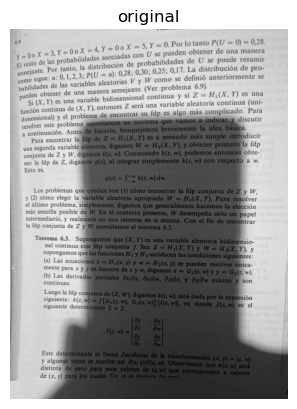

In [178]:
mask = dilation(image=mask, selem=disk(40))

imprimir_pic(mask,'Máscara')
imprimir_pic(input_pic,'original')


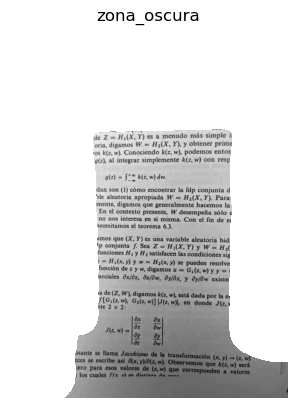

In [179]:
zona_oscura = np.full(input_pic.shape,np.nan)
limite = np.nanmean(input_pic)
for (coor_y,coor_x), value in np.ndenumerate(input_pic): 
    aux = mask[coor_y:coor_y+1,coor_x:coor_x+1]
    if aux<limite: #Good Pixel
        zona_oscura[coor_y,coor_x] =  input_pic[coor_y,coor_x] 
    elif aux>limite: #Bad Pixel
        None             
imprimir_pic(zona_oscura,"zona_oscura")

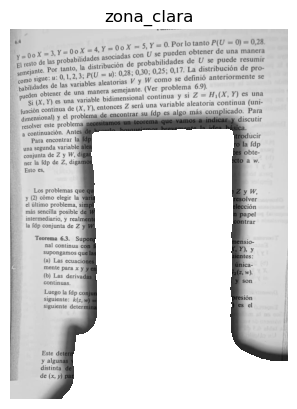

In [180]:
zona_clara = np.full(input_pic.shape,np.nan)
limite = np.nanmean(input_pic)

for (coor_y,coor_x), value in np.ndenumerate(input_pic): 
    aux = mask[coor_y:coor_y+1,coor_x:coor_x+1]
    if aux>limite: #Good Pixel
        zona_clara[coor_y,coor_x] =  input_pic[coor_y,coor_x] 
    elif aux<=limite: #Bad Pixel
        None
        
imprimir_pic(zona_clara,"zona_clara")  

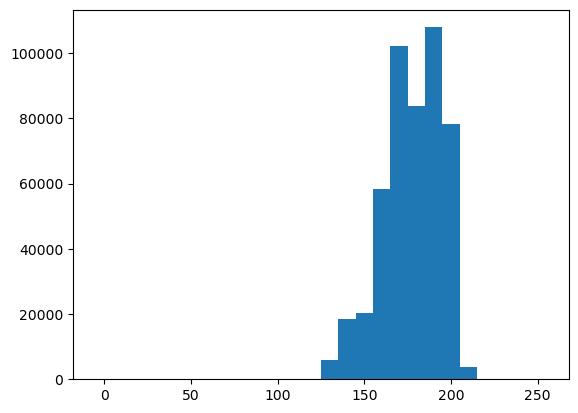

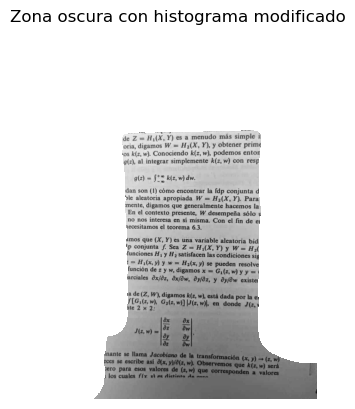

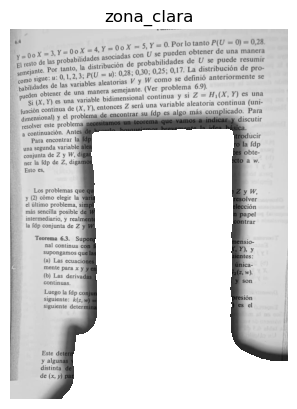

In [181]:

#a,b = np.histogram(zona_clara,bins=np.arange(0,270,10))
#plt.bar( b[0:26],a[0:26],width=10)
#moda_zona_clara = b[np.argmax(a)+1]
#
#a,b = np.histogram(zona_oscura,bins=np.arange(0,270,10))
#plt.bar( b[0:26],a[0:26],width=10)
#moda_zona_oscura = b[np.argmax(a)+1]

osc = np.copy(zona_oscura) + ( -moda_zona_oscura + moda_zona_clara)
#osc = zona_oscura
lessThen0 = osc<0
moreThen255 = osc>255
osc[lessThen0] = 0
osc[moreThen255] = 255
#imprimir_pic(osc,"osc")
a,b = np.histogram(osc,bins=np.arange(0,270,10))
plt.bar( b[0:26],a[0:26],width=10)
#moda_zona_oscura = b[np.argmax(a)+1]
imprimir_pic(osc,"Zona oscura con histograma modificado")
imprimir_pic(zona_clara,"zona_clara")

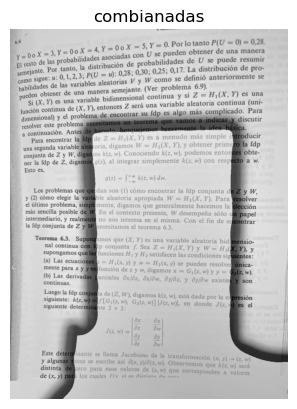

In [182]:
z1 =  np.nan_to_num(zona_clara,0)
z2 = np.nan_to_num(osc,0)

suma_parcial = (z1 + z2)
imprimir_pic(suma_parcial,"combianadas")

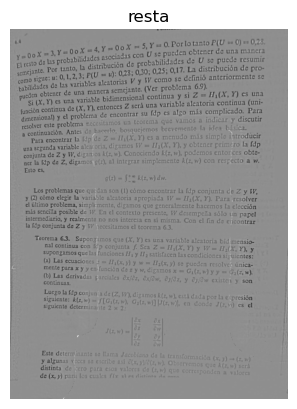

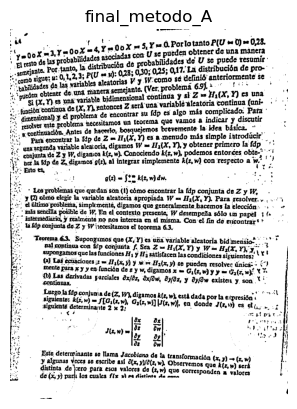

In [183]:
resta_parcial = np.copy(suma_parcial)

mask_gris = ndimage.median_filter(suma_parcial, size=15,mode='reflect')


resta_parcial = ((suma_parcial - mask_gris)+255)/(2)
lessThen0 = resta_parcial<0
moreThen255 = resta_parcial>255
resta_parcial[lessThen0] = 0
resta_parcial[moreThen255] = 255


imprimir_pic(resta_parcial,"resta") 
p_indicado = contraste_optimo_por_MSE(255 - resta_parcial,255 - input_pic)
final_metodo_A = funcion_de_contraste(resta_parcial,p_indicado)
imprimir_pic(final_metodo_A,"final_metodo_A") 


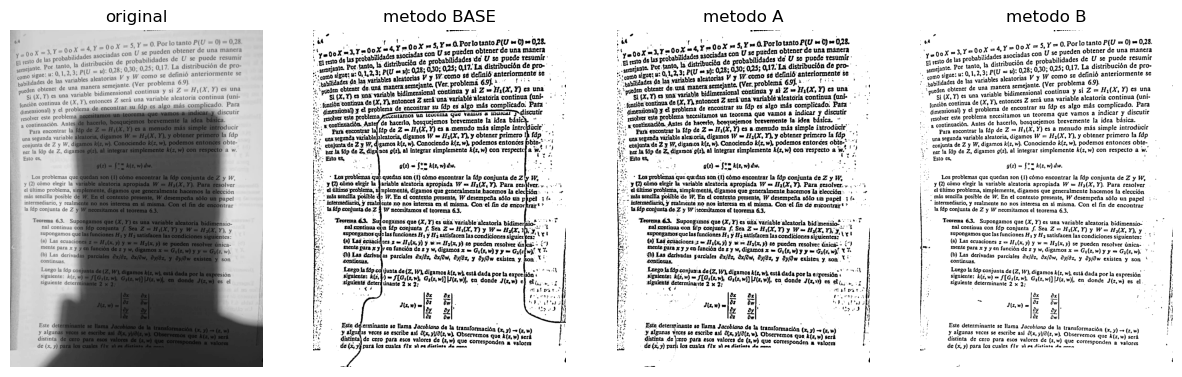

In [184]:
plt.figure(figsize=(15,12))
plt.subplot(1,4, 1)
plt.imshow(input_pic, cmap = 'gray')
plt.title('original')
plt.axis('off')

plt.subplot(1,4, 2)
plt.imshow(final_metodo_BASE, cmap = 'gray')
plt.axis('off')
plt.title('metodo BASE')



plt.subplot(1,4, 3)
plt.imshow(final_metodo_A, cmap = 'gray')
plt.axis('off')
plt.title('metodo A')

plt.subplot(1,4, 4)
plt.imshow(threshold_image, cmap = 'gray')
plt.axis('off')
plt.title('metodo B')
plt.show()

#### Guardamos el mejor resultado como archivo jpeg

In [185]:
type(threshold_image)

PIL.Image.Image

In [186]:
nombre = imagen_entrada + "_PROCESADA.jpeg"

threshold_image.save(nombre)
